# Using StatsModel for forcasting
## Ref Used :- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

### For implementing Stats model I have used the above URL. Here the data is first saved into dataframe. After saving the data frame, dataframe is saved as csv. Now the model is predicted based on the csv data.

In [2]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import sys

import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np 
from pandas import DataFrame, Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from pandas import read_csv
from pandas import datetime

import statsmodels.api as sm

ModuleNotFoundError: No module named 'tensorflow'

## Reading saved JSON file for fetched issues

In [225]:
# Read the JSON file into a list of dictionaries

import json
list_of_issues_dict_data = [json.loads(line) for line in open('SPM587SP19issues.json')]

In [226]:
# Create the DataFrame object for the list_of_issues_dict_data object

issues_df = DataFrame(list_of_issues_dict_data)

## Preparing DataFrame object based on labels

In [246]:
# Prepare and Clean the dataframe object

wrangled_issues_df = issues_df[['Author','State','closed_at','created_at','issue_number','labels']]
wrangled_issues_df.loc[0:len(wrangled_issues_df), 'OriginationPhase']= np.NaN
wrangled_issues_df.loc[0:len(wrangled_issues_df),'DetectionPhase']= np.NaN
wrangled_issues_df.loc[0:len(wrangled_issues_df),'Category']= np.NaN
wrangled_issues_df.loc[0:len(wrangled_issues_df),'Priority']= np.NaN
wrangled_issues_df.loc[0:len(wrangled_issues_df),'Status']= np.NaN

for i in range(0, len(wrangled_issues_df)):
    if wrangled_issues_df.iloc[i]['labels']:
        for label in wrangled_issues_df.iloc[i]['labels']:
            label_name= (label.split(':'))[0]
            label_value= (label.split(':'))[1]
            wrangled_issues_df.loc[i, label_name]=label_value
 

In [247]:
# Sanity Check of records
wrangled_issues_df[:5]

,Author,State,closed_at,created_at,issue_number,labels,OriginationPhase,DetectionPhase,Category,Priority,Status,Address,OritinationPhase,Latitude,Longitude,Detection,Origination
0,TSP19SCM781,open,None,2019-04-21,494,"[Category:Enhancement, DetectionPhase:Testing,...",Field,Testing,Enhancement,Critical,Completed,NaN,NaN,NaN,NaN,NaN,NaN
1,TSP19SCM781,open,None,2019-04-21,493,"[Category:Enhancement, DetectionPhase:Design, ...",Design,Design,Enhancement,Major,Completed,NaN,NaN,NaN,NaN,NaN,NaN
2,TSP19SCM781,open,None,2019-04-21,492,"[Category:Inquiry, DetectionPhase:Design, Orig...",Requirements,Design,Inquiry,Major,inProgress,NaN,NaN,NaN,NaN,NaN,NaN
3,DSP19SCM782,open,None,2019-04-21,491,"[Category:Bug, DetectionPhase:Field, Originati...",Field,Field,Bug,Major,pendingReview,NaN,NaN,NaN,NaN,NaN,NaN
4,DSP19SCM782,open,None,2019-04-21,490,"[Category:Bug, DetectionPhase:Design, Originat...",Testing,Design,Bug,High,pendingReview,NaN,NaN,NaN,NaN,NaN,NaN


## Date Parser used for Stats Model for parsing date.

In [229]:
# parser for date in stats model
def parser(x):
    return datetime.strptime(x,'%Y-%m-%d')


## Stats model training and predection function

In [248]:
# Stats model training and predection
def stats_model_train_predict(file_name_csv, order):
    series = read_csv(file_name_csv, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    X = series.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order[0])
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    
    pyplot.figure(figsize=(15, 5))
    pyplot.plot(test, "b", label="Expected")
    pyplot.plot(predictions, "r", label="Predicted")
    pyplot.legend(loc=0)
    pyplot.title("Stat Model Prediction")
    pyplot.show()
    return predictions

## 6.1 The day of the week maximum number of issues created

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


predicted=24.805882, expected=35.000000
predicted=28.878592, expected=12.000000


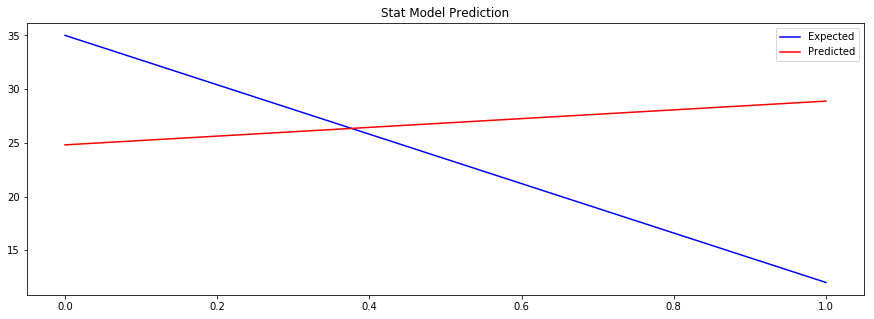

[array([24.80588248]), array([28.87859192])]

In [249]:
# The day of the week maximum number of issues created
df = wrangled_issues_df.groupby('created_at')['created_at']
df_new = df.describe()
new_col = pd.Series(df_new['top'], name='date')

#Creating a new dataframe for capturing copy of dates
df_new = pd.concat([df_new, new_col], axis=1)
temp_df = pd.DataFrame(['ds','ds_actual','y'])
temp_df = df_new[['top','date','count']]
temp_df.columns = ['ds','ds_actual','y']

#Generating Monday for any given date and grouping by using the week
temp_df['ds'] = pd.to_datetime(temp_df['ds']) - pd.to_timedelta(7, unit='d')
df_weekly_max_count = temp_df.reset_index().groupby(
    [pd.Grouper(key='ds', freq='W-MON')]).apply(lambda x: x.loc[x.y == x.y.max(),['ds_actual','y']])

# Again fetching the grouped data and storing it into a new dataframe that is used for plotting
df_forPrediction = pd.DataFrame(['ds','y'])
df_forPrediction = df_weekly_max_count[['ds_actual','y']]
df_forPrediction.columns = ['ds','y']
export_csv = df_forPrediction.to_csv (r'./export_dataframe_stats_model.csv', index = None, header=True) 
stats_model_train_predict('export_dataframe_stats_model.csv',[(1,0,0)])

## 6.2 The day of the week maximum number of issues closed

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/anaconda3/lib/pytho

predicted=30.325765, expected=41.000000
predicted=33.444238, expected=11.000000


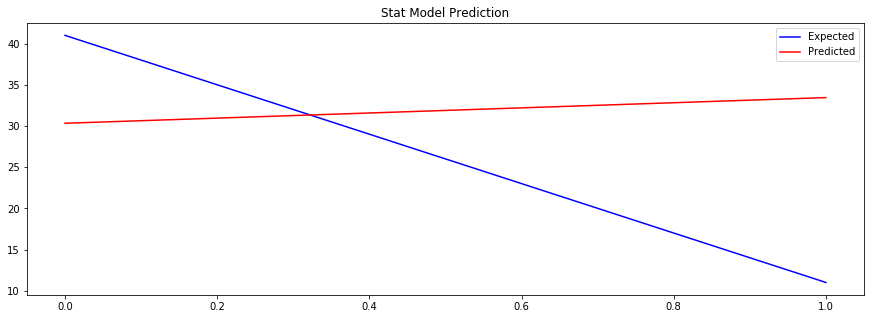

[array([30.32576483]), array([33.44423771])]

In [250]:
#The day of the week maximum number of issues closed
df_closed = wrangled_issues_df[(wrangled_issues_df['State'] == 'closed')]
df_closed_gby = df_closed.groupby(['closed_at','State'])['closed_at']

df_new = df_closed_gby.describe()
new_col = pd.Series(df_new['top'], name='date')

#Creating a new dataframe for capturing copy of dates
df_new = pd.concat([df_new, new_col], axis=1)
temp_df = pd.DataFrame(['ds','ds_actual','y'])
temp_df = df_new[['top','date','count']]
temp_df.columns = ['ds','ds_actual','y']

#Generating Monday for any given date and grouping by using the week
temp_df['ds'] = pd.to_datetime(temp_df['ds']) - pd.to_timedelta(7, unit='d')
df_weekly_max_count = temp_df.reset_index().groupby(
    [pd.Grouper(key='ds', freq='W-MON')]).apply(lambda x: x.loc[x.y == x.y.max(),['ds_actual','y']])

# Again fetching the grouped data and storing it into a new dataframe that is used for plotting
df_forPrediction = pd.DataFrame(['ds','y'])
df_forPrediction = df_weekly_max_count[['ds_actual','y']]
df_forPrediction.columns = ['ds','y']
export_csv = df_forPrediction.to_csv (r'./export_dataframe_stats_model.csv', index = None, header=True) 
stats_model_train_predict('export_dataframe_stats_model.csv',[(1,0,0)])

## 6.3 Plot the created issues forecast and passing in your forecast dataframe.

predicted=16.719490, expected=12.000000
predicted=7.847319, expected=10.000000
predicted=14.933823, expected=10.000000
predicted=24.449527, expected=10.000000
predicted=10.451552, expected=10.000000
predicted=11.458012, expected=12.000000
predicted=11.797688, expected=7.000000
predicted=9.117349, expected=8.000000


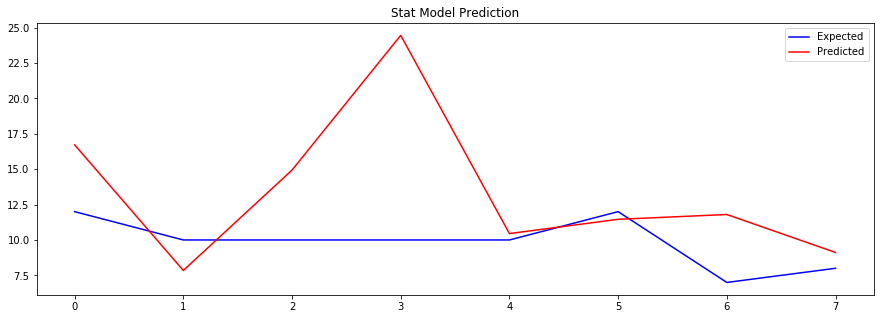

[array([16.71949015]),
 array([7.84731915]),
 array([14.93382322]),
 array([24.4495271]),
 array([10.4515522]),
 array([11.45801191]),
 array([11.79768791]),
 array([9.1173486])]

In [251]:
#Plot the created issues forecast by calling the Prophet.plot method and passing in your forecast dataframe.

df = wrangled_issues_df.groupby('created_at')['created_at']
#print(df.count().idxmax())
df_new = df.describe()
df_new['count']
df_new['top']
sdf = pd.DataFrame()
sdf = df_new[['top','count']]
sdf.columns = ['ds','y']
export_csv = sdf.to_csv (r'./export_dataframe_stats_model.csv', index = None, header=True) 
stats_model_train_predict('export_dataframe_stats_model.csv',[(5,1,0)])


## 6.4 Plot the closed issues forecast. Showing trend yearly seasonality, and weekly seasonality of the time series.


predicted=43.083658, expected=11.000000
predicted=29.618753, expected=12.000000
predicted=16.842333, expected=10.000000
predicted=7.728128, expected=10.000000
predicted=11.411172, expected=7.000000
predicted=8.949865, expected=4.000000
predicted=6.252343, expected=2.000000
predicted=3.055763, expected=1.000000


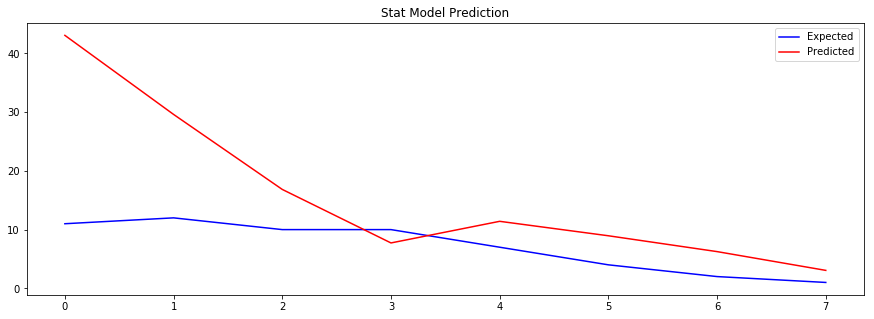

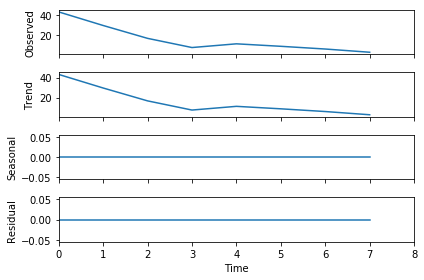

In [252]:
# Plot the closed issues forecast; use the Prophet.plot_components method. 
# By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. 
# If you include holidays, you’ll see those here, too.

df_closed = wrangled_issues_df[(wrangled_issues_df['State'] == 'closed')]
df_closed_gby = df_closed.groupby(['created_at','State'])['created_at']

df_new = df_closed_gby.describe()
pdf = pd.DataFrame(['ds','y'])
pdf = df_new[['top','count']]
pdf.columns = ['ds','y']

export_csv = pdf.to_csv (r'./export_dataframe_stats_model.csv', index = None, header=True) 
predicted_data = stats_model_train_predict('export_dataframe_stats_model.csv',[(3,1,0)])

result = seasonal_decompose(list(predicted_data), model='additive', freq=1)
result.plot()
pyplot.show()

## Reading saved JSON file for fetched pulls

In [253]:
# Read the JSON file into a list of dictionaries

import json
list_of_pulls_dict_data = [json.loads(line) for line in open('SPM587SP19pulls.json')]

# Create the DataFrame object for the list_of_issues_dict_data object

pulls_df = DataFrame(list_of_pulls_dict_data)

In [236]:
# Sanity Check
pulls_df[:10]

,Author,State,closed_at,created_at,issue_number,labels
0,JSP19SCM03G,closed,2019-04-20,2019-04-20,481,[]
1,YSP19SCM26X,closed,2019-04-19,2019-04-19,478,[]
2,YSP19SCM26X,closed,2019-04-18,2019-04-18,466,[]
3,SSP19SCM81Y,closed,2019-04-20,2019-04-13,424,[]
4,JSP19SCM33G,closed,2019-04-11,2019-04-11,411,[]
5,HSP19SCM81A,closed,2019-04-11,2019-04-11,399,[]
6,HSP19SCM81A,closed,2019-04-11,2019-04-10,398,[]
7,MSP19SCM07P,closed,2019-04-10,2019-04-10,386,[]
8,ASP19SCM59K,closed,2019-04-10,2019-04-10,385,[]
9,PSP19SCM76K,closed,2019-04-10,2019-04-10,384,[]


## 6.5 Plot the closed issues forecast on the received data

predicted=26.362162, expected=19.000000
predicted=11.604970, expected=2.000000
predicted=1.120475, expected=1.000000
predicted=12.091936, expected=1.000000
predicted=0.468713, expected=1.000000
predicted=-0.049885, expected=1.000000


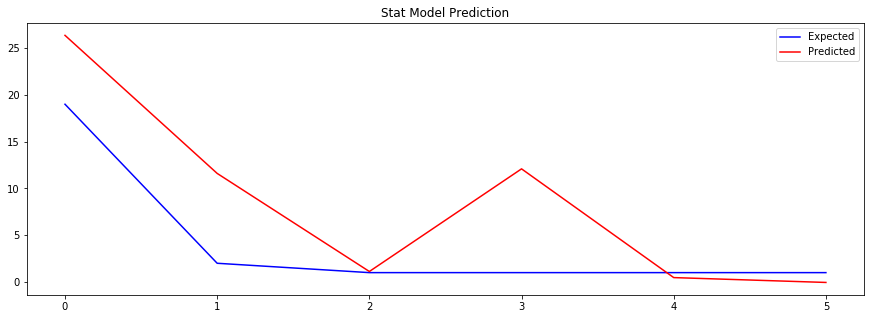

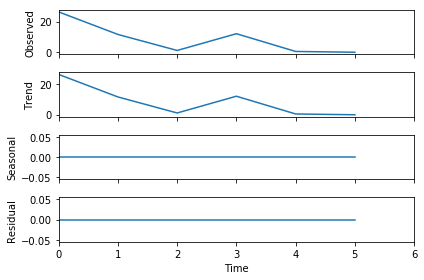

In [254]:
# Plot the pulls forecast; use the Prophet.plot_components method. 
# By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. 
# If you include holidays, you’ll see those here, too.

df_created = pulls_df.groupby(['created_at'])['created_at']
df_new = df_created.describe()
pdf_pull = pd.DataFrame(['ds','y'])
pdf_pull = df_new[['top','count']]
pdf_pull.columns = ['ds','y']

export_csv = pdf_pull.to_csv (r'./export_dataframe_stats_model.csv', index = None, header=True) 
predicted_data = stats_model_train_predict('export_dataframe_stats_model.csv',[(2,1,0)])

result = seasonal_decompose(list(predicted_data), model='additive', freq=1)
result.plot()
pyplot.show()

## Reading saved JSON file for fetched commits

In [255]:
# Read the JSON file into a list of dictionaries

import json

file = open("SPM587SP19commits.json", "r") 
list_of_commit_dict_data = [json.loads(line) for line in open('SPM587SP19commits.json')]
commits_df = DataFrame(list_of_commit_dict_data)

In [239]:
# Sanity Check
commits_df[:10]

,created_at
0,2019-04-20
1,2019-04-20
2,2019-04-20
3,2019-04-20
4,2019-04-20
5,2019-04-19
6,2019-04-19
7,2019-04-18
8,2019-04-18
9,2019-04-18


## 6.6 Plot the commits forecast based on received data.

/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


predicted=31.240294, expected=61.000000
predicted=62.639017, expected=58.000000
predicted=54.365973, expected=3.000000
predicted=9.035996, expected=1.000000
predicted=7.363510, expected=4.000000
predicted=4.842703, expected=2.000000
predicted=27.176141, expected=5.000000


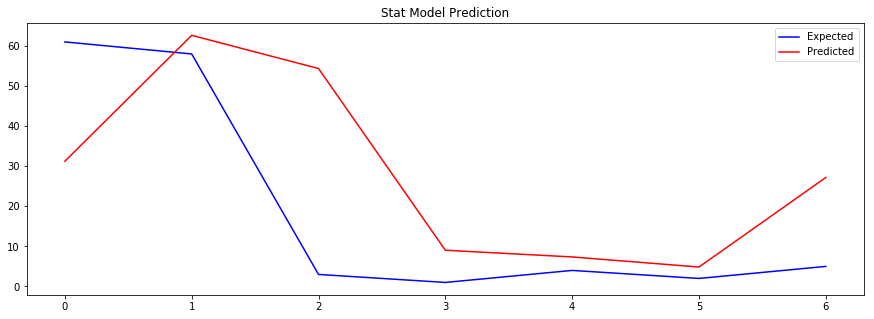

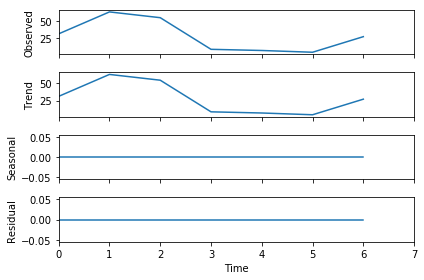

In [256]:
# Plot the commits forecast; use the Prophet.plot_components method. 
# By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. 
# If you include holidays, you’ll see those here, too.

df_created = commits_df.groupby(['created_at'])['created_at']
df_new = df_created.describe()
pdf_commits = pd.DataFrame(['ds','y'])
pdf_commits = df_new[['top','count']]
pdf_commits.columns = ['ds','y']


export_csv = pdf_commits.to_csv (r'./export_dataframe_stats_model.csv', index = None, header=True) 
predicted_data = stats_model_train_predict('export_dataframe_stats_model.csv',[(5,1,0)])

result = seasonal_decompose(list(predicted_data), model='additive', freq=1)
result.plot()
pyplot.show()